# 4. Value at Risk and Its Application with Python
## Anthony Ochieng

Banking industry undertakes countless number of transactions in an ordinary day ranging from low to high risk. However, it is not how many transaction a bank can do in a day that matters. Rather, despite the high volume, if a bank can manage its risk without sacrificing its profit too much, that is a good banking practice. Monitoring and managing the risk have been a long standing issue. To remedy this problem, each bank developed their own risk system however the diversity of the risks faced by companies, the difficulties in measuring the effects of these risks, and the change of risk factors over time have led regulators to establish a standard methodology.

Thus, in order to measure the exposed risk in a day-to-day operations, in the late 1980s, J.P. Morgan developed `Value-at-Risk` (VaR) model, which is easy-to-apply and intuitive method. 

we will discuss the widely applicable risk measuring techniques and its application in Python. These techniques are:
* Value-at-Risk
* Credit Value-at-Risk

## 4.1. Value-at-Risk

Generally speaking, `VaR` is a method developed for measuring the likely loss of an asset or a portfolio over given time and confidence interval. More specifically, assume that, at 95% confidence interval, VaR of an asset or a portfolio is 1 million USD in a day meaning that 95% chance we have 1 million USD loss in a day at most. In other words, there is only a 5% chance that we loss more than 1 million USD in a day.

There are some important points in VaR analysis that needs to be highlighted:
    * VaR needs an estimation of the probability of loss
    * VaR concentrates on the potential losses. We are not talking about actual or realized losses rather VaR is a kind of loss projection
    * VaR has three key ingredients: 
        * Standard deviation that defines the level of loss
        * Fixed time horizon over which risk is assessed
        * Confidence Interval

<img src="../assets/VAR Dan G 2015.png" alt="VaR Illustration" style="width:150;height:300px;">

**Source:** Dan, G. (2015)

As in other models, VaR also has certain advantages and disadvantages:

**Advantages**
* It implies important insights about the potential risk
- It is an easy method to understand

**Disadvantages**

* Historical data might be misleading
* Some assumptions might lead to biased results
* Extraordinary events do not considered in VaR


In the literature, different VaR techniques stand out among which `Variance-Covariance Method` and `Monte Carlo Simulation` are the most prominent ones. In this lesson, we will theoretically discuss and learn how to apply them in Python.

### 4.1.1. Variance-Covariance Method VaR

In many parametric models in finance, returns are generally assumed to be normally distributed. In this method, we obtain standard deviaton and correlation structure of historical returns and expected losses are computed.

The formula of Variance-Covariance VaR is as follows:

$$\text{VaR}=V*\sigma_p*\sqrt{t}*Z_{\alpha}$$

where
* V: Value of the portfolio
* $\sigma_p$: Standard Deviation of the portfolio
* t: Holding Period
* $Z_\alpha$: A value corresponding the confidence interval in Normal Distribution Table

If VaR analysis is conducted over a single asset then we substitute $\sigma_p$ with $\sigma$ and the rest of the inputs stays as they are.

The variance-covariance method borrows its name from the following operation. In determining the value of $\sigma_p$, we take into account the correlation structure among assets in a portfolio. For the sake of easiness, let's assume that we have 2-asset portfolio:

$$\sigma_p=\sqrt{w_1^2\sigma_1^2+w_2^2\sigma_2^2+\rho w_1w_2\sigma_1\sigma_2}$$

where w is the weight of the asset in the portfolio.

Now, it is time to learn how to apply Variance-Covariance VaR analysis in Python.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy.stats import norm
import seaborn as sns; sns.set()

We will use the same stocks and time period as we did in volatility analysis:

In [2]:
stocks = ['F','BLK','GOOG','AMZN']
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2020,4,1)
stock_prices = yf.download(stocks,start=start,end = end, interval='1d')['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [3]:
returns = stock_prices.pct_change()

In [4]:
returns.dropna(inplace=True)
returns.head()

,AMZN,BLK,F,GOOG
Date,,,,
2010-01-04,-0.004609,0.027476,0.028000,0.010920
2010-01-05,0.005900,0.004318,0.066148,-0.004404
2010-01-06,-0.018116,-0.020617,0.037408,-0.025209
2010-01-07,-0.017013,0.010994,0.025506,-0.023280
2010-01-08,0.027077,0.007039,0.002572,0.013331


Let's generate variance-covariance matrix. This is really easy as pie with Python:

In [5]:
cov_var_matrix=returns.cov()
cov_var_matrix

,AMZN,BLK,F,GOOG
AMZN,0.000391,0.000144,0.000131,0.000182
BLK,0.000144,0.000306,0.000189,0.000146
F,0.000131,0.000189,0.000353,0.000120
GOOG,0.000182,0.000146,0.000120,0.000259


Here, we have the variance-covariance matrix. The diagonal elements give us the variance of the related stock and off-diagonal elements show the covariance of the stocks. For instance, return variance of `Amazon`is 0.000391 and covariance between BlackRock and Ford is 0.00019.

Now, we calculate the variance-covariance matrix and are ready to derive portfolio standard deviation, which is nothing but a square root of the dot product as given:

$$w^T\Sigma w$$

where w is weight and $\Sigma$ is variance-covariance matrix

In [6]:
def var_cov_VaR():
    conf_level = 0.95
    initial_investment=1e6
    weights  = np.random.random(len(returns.columns))
    weights /= np.sum(weights)
    port_std = np.sqrt(weights.T.dot(cov_var_matrix).dot(weights))
    VaR = initial_investment*port_std*norm.ppf(conf_level)
    return VaR

In [7]:
VaR=var_cov_VaR()
print("The Value at Risk at 95% confidence interval is {}".format(int(VaR)))

The Value at Risk at 95% confidence interval is 22763


The VaR value of $24203 tells us that an investment of 1M USD will not exceed losses greater than 24203 USD at 95% confidence interval over `a day`.

The question is now how can we calculate the VaR over longer period because it is quite natural to have an idea about risk over longer period. Based on the model provided above, it is an easy task all we need to do is to multiply the VaR result by a factor of $\sqrt t$ where t is time horizon and it start with 1 day ends with 30 in this case:

In [8]:
def daily_var():
    var_horizon=[]
    time_horizon = 30
    for i in range(1, time_horizon+1):    
        var_horizon.append(VaR * np.sqrt(i))
        print(str(i) + " daily VaR is:{:.2f} ".format(VaR * np.sqrt(i)))
    plt.xlabel("Days")
    plt.ylabel("USD")
    plt.title("VaR over 30-day period")
    plt.plot(var_horizon, "o",c='blue')

1 daily VaR is:22763.33 
2 daily VaR is:32192.21 
3 daily VaR is:39427.24 
4 daily VaR is:45526.66 
5 daily VaR is:50900.35 
6 daily VaR is:55758.54 
7 daily VaR is:60226.11 
8 daily VaR is:64384.42 
9 daily VaR is:68289.99 
10 daily VaR is:71983.97 
11 daily VaR is:75497.43 
12 daily VaR is:78854.49 
13 daily VaR is:82074.35 
14 daily VaR is:85172.58 
15 daily VaR is:88162.00 
16 daily VaR is:91053.32 
17 daily VaR is:93855.62 
18 daily VaR is:96576.63 
19 daily VaR is:99223.06 
20 daily VaR is:101800.71 
21 daily VaR is:104314.68 
22 daily VaR is:106769.48 
23 daily VaR is:109169.10 
24 daily VaR is:111517.09 
25 daily VaR is:113816.65 
26 daily VaR is:116070.67 
27 daily VaR is:118281.73 
28 daily VaR is:120452.22 
29 daily VaR is:122584.29 
30 daily VaR is:124679.90 


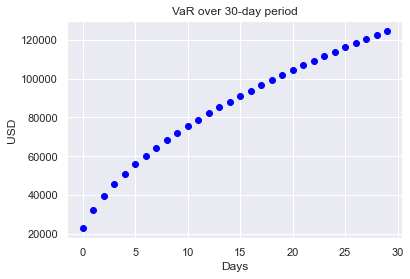

In [9]:
daily_var()

### 4.1.2. Monte Carlo Simulation VaR

Monte Carlo Simulation is applicable to porfolios including stocks with non-linear return structure. In essence, it is similar to variance-covariance method but there is a main difference between these two methods. While the variance-covariance method incorporates real historical stock returns, Monte Carlo Simulation VaR employs a simulated random numbers generating from a statistical distribution mimicking the behavior of a real stock returns.

I am sure that you all remember the [Simulation Analysis and Its Application in Python Lesson](http://localhost:8888/notebooks/Python_For_Finance/Scenario_2/Simulation_Analysis_and_Its_Application_in_Python.ipynb) and how we derive `Geometric Brownian Motion`. Now, let's take advantage of it in Monte Carlo Simulation VaR.

In [10]:
def brownian_motion(T, N):
    """
    T: total time
    N: The total number of steps
    W0: First Value of Brownian Motion
    dt: Time increment
    """
    W0 = 0
    dt = T/N
    increments = np.random.normal(0, 1*np.sqrt(dt), N)
    W = W0 + np.cumsum(increments)
    return W

In [11]:
T=1
N=10**3 
dt = T / float(N)
t=np.linspace(0.,N*dt,N)
conf_level=0.95
iterations=10000
V=1e6

In [12]:
def MC_VaR(V):
    W=brownian_motion(T, N)
    MC_VaR=V*np.std(W)*norm.ppf(conf_level)
    return MC_VaR

In [13]:
MC_VaR=MC_VaR(V)

In [14]:
print("At 95% Confidence Interval VaR is {:.2f}".format(MC_VaR))

At 95% Confidence Interval VaR is 669703.66


Monte Carlo Simulation VaR suggests a result of 500919.19 USD indicating that the potential loss at the given confidence interval cannot exceed 500919.19 USD and there is also 5% likelihood that the loss can even excess 500919.19 USD

In [15]:
def daily_MC_var():
    var_horizon=[]
    time_horizon = 30
    for i in range(1, time_horizon+1):    
        var_horizon.append(MC_VaR * np.sqrt(i))
        print(str(i) + " daily VaR is:{:.2f} ".format(MC_VaR * np.sqrt(i)))
    plt.xlabel("Days")
    plt.ylabel("USD")
    plt.title("MC VaR over 30-day period")
    plt.plot(var_horizon, "o",c='blue')

1 daily VaR is:669703.66 
2 daily VaR is:947103.99 
3 daily VaR is:1159960.76 
4 daily VaR is:1339407.31 
5 daily VaR is:1497502.90 
6 daily VaR is:1640432.24 
7 daily VaR is:1771869.33 
8 daily VaR is:1894207.99 
9 daily VaR is:2009110.97 
10 daily VaR is:2117788.91 
11 daily VaR is:2221155.75 
12 daily VaR is:2319921.52 
13 daily VaR is:2414650.87 
14 daily VaR is:2505801.63 
15 daily VaR is:2593751.11 
16 daily VaR is:2678814.63 
17 daily VaR is:2761258.91 
18 daily VaR is:2841311.98 
19 daily VaR is:2919170.56 
20 daily VaR is:2995005.80 
21 daily VaR is:3068967.70 
22 daily VaR is:3141188.58 
23 daily VaR is:3211785.91 
24 daily VaR is:3280864.47 
25 daily VaR is:3348518.28 
26 daily VaR is:3414832.01 
27 daily VaR is:3479882.28 
28 daily VaR is:3543738.65 
29 daily VaR is:3606464.56 
30 daily VaR is:3668117.99 


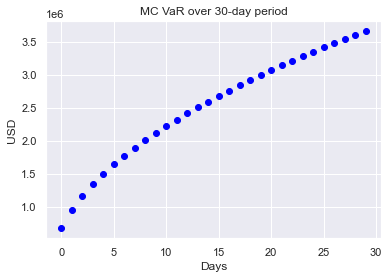

In [16]:
daily_MC_var()

## 4.2. Credit Value-at-Risk (CVaR)

Credit risk occurs when counterpart are not able to honor its debt. This risk is assessed by financial instutions on a regular basis. Credit Value-at-Risk (CVaR) is one of the a widely appreciated tools to run this assessment regularly. 

Th logic of VaR applies here but in a different way. In CVaR, we are not inferring from the value of a portfolio, rather CVaR is based on the loss distribution of a portfolio or a single stock. We have two different of losses in a portfolio:
* Expected Loss
* Unexpected Loss

The `Expected Loss` is the loss that are expected to happen and it is considered in pricing an asset. It is basically the sum of all likely losses of an asset in a portfolio meaning that mean of these losses correspond to expected loss. Technically speaking, the expected loss is the average loss that we would expect from an exposure over a given period of time.

The `Unexpected Loss`, on the other hand, is the total loss over and above expected loss. It is the difference between high percentile such as 99.9 as given below and the expected loss. It is also referred to as `Credit Value at Risk`.

<img src="../assets/EL-UEL.png" alt="EL/UEL Illustration" style="width:150;height:300px;">

**Source:** Serraino G., Uryasev S. (2013)

The above-give graph illustrates the expected and unexpected losses. Please keep in mind that this is **not** a value distribution of a portfolio, it is a `loss` distribution. The mean of this skewed distribution gives us the expected loss and the portion between expected loss and high percentile amounts to unexpected loss, i.e. `CVAR`.

Time to practice! From the previous lessons, we know how to draw random samples from a distribution. This time, we draw random samples from log-normal distribution but before that let's import the necessary libraries along the way:

In [17]:
from scipy.stats import poisson
from scipy import stats
from matplotlib  import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

Hull (2015) describes the general shape of probability distribution of default losses with following graph. It is readily observable that the loss distribution is right-skewed, i.e. the outliers gather around the tail on the right-hand side. In other words, having large losses is a rare event but it is highly likely to have small amount of losses.

<img src="../assets/loss_dist.png" alt="Loss Distribution" style="width:150;height:300px;">

Source: Risk Management and Financial Instutitions (2015)

Practically, `log normal distribution` is the best fit of loss severity distribution, i.e. a probability distribution of the amount of losses incurred per event. Let's now fit our random samples from Poisson distribution to lognormal distribution. Log normal distribution has three outputs:

shape, loc, scale = lognorm.fit(data)

* `shape` 
* `loc` is mean
* `scale` is standard deviation

After importing required libraries, generating random number from log-normal distribution is the first step. Subsequent to having log-normally distributed random number, we need to fit it to the log-normal distribution to obtain the `shape`, `loc`, and `scale` that will be used as initial parameters in Monte Carlo Simulation process. Then histogram tells us what our data looks like.

Before you start searching, let me explain what is the function of `normed` in histogram. `Normed` regularizes the y-axis for us by calculating the percentage frequency. Without it, we have number of occurences on the y-axis. 

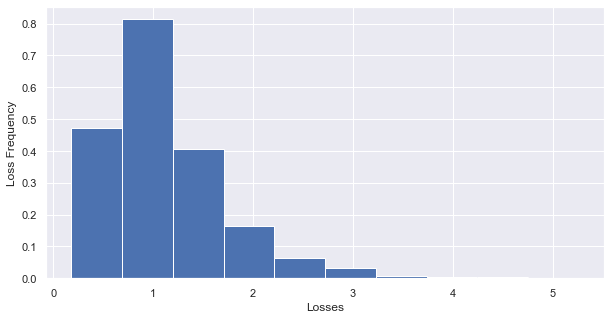

In [18]:
plt.figure(figsize=(10, 5))
loss = stats.lognorm(0.5,loc=0,scale=1).rvs(size=2000)
shape, loc, scale=stats.lognorm.fit(loss)
plt.hist(loss,density=True)
plt.xlabel('Losses')
plt.ylabel('Loss Frequency')
plt.show()

We continue out hypothetical case using randomly generated data following log-normal distribution.

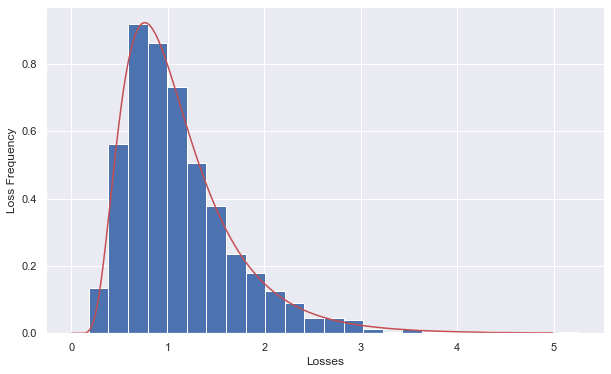

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(loss, density=True, bins=25 )
plt.xlabel('Losses')
plt.ylabel('Loss Frequency')

x = np.arange(0, 5, 0.01)
shape, loc, scale = stats.lognorm.fit(loss)
pdf = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)
plt.plot(x, pdf, 'r')
plt.show()

In [20]:
loss = stats.lognorm(0.5,loc=0,scale=1).rvs(size=2000)
shape, loc, scale=stats.lognorm.fit(loss)

In [21]:
lamda=3
threshold=np.random.random()
def loss_fn(loc, shape, scale, lamda,threshold):
    X = []
    for i in range(6):  
        if (threshold<poisson.cdf(i, lamda)):
            ind_loss=0
        else:
            ind_loss = stats.lognorm.rvs(s=shape, loc=loc, scale=scale)
        X.append(ind_loss)   
    return np.sum(X)

In [22]:
losses = []
iterations=10000
for _ in range(iterations):
    threshold= np.random.random()
    losses.append(loss_fn(loc,shape, scale, lamda,threshold))

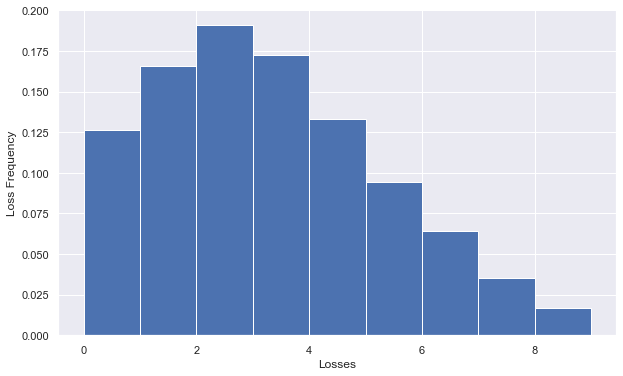

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(losses, density=True, bins=range(0, 10))
plt.xlabel('Losses')
plt.ylabel('Loss Frequency')
plt.show()

In [24]:
print("Mean value of losses is {:.2f}".format(np.mean(losses)))
print("95% confidence interval corresponds to {:.2f}".format(np.percentile(losses,95)))

Mean value of losses is 3.39
95% confidence interval corresponds to 7.25


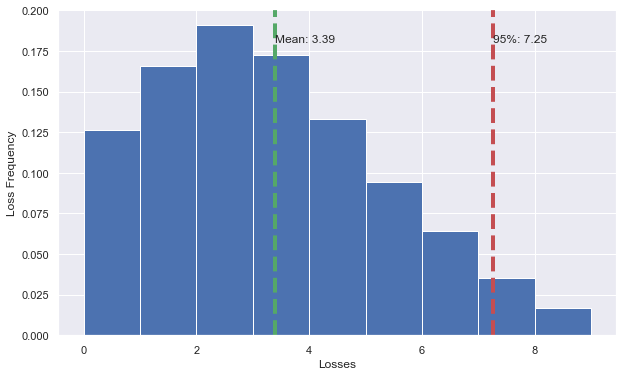

In [25]:
plt.figure(figsize=(10, 6))
h = plt.hist(losses, bins=range(0, 10),density=True)
plt.axvline(np.mean(losses), color='g', linestyle='dashed', linewidth=4)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(losses), max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(losses)))
plt.axvline(np.percentile(losses,95), color='r', linestyle='dashed', linewidth=4)
plt.text(np.percentile(losses,95), max_ylim*0.9, '95%: {:.2f}'.format(np.percentile(losses,95)))
plt.xlabel('Losses')
plt.ylabel('Loss Frequency')
plt.show()

So, as the CVaR is unexpected loss, which is difference between mean of losses and 95th-percentile losses (in our case), it corresponds to **4** (7.29-3.29).

# Conclusion

As a widely applicable industry practice, Value-at-Risk has still good reputation despite some disadvantages. The ultimate goal of this lesson is to introduce the theoretical and empirical foundations of Value-at-Risk and Credit Value-at-Risk.

As you see, Python provides us a convenient platform to run these analysis. Now, it is your turn to get your hand dirty.

**References**

* [Dan, G. (2015)](https://www.researchgate.net/publication/283563698_Aspects_of_Modeling_Fraud_Prevention_of_Online_Financial_Services). Aspects of Modeling Fraud Prevention of Online Financial Services (Doctoral dissertation, KTH Royal Institute of Technology

* Serraino G., Uryasev S. (2013) Conditional Value-at-Risk (CVaR). In: Gass S.I., Fu M.C. (eds) Encyclopedia of Operations Research and Management Science. Springer, Boston, MA